In [121]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import glob

import healpy

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

from astropy.table import Table, vstack
from astropy.io import fits

from shapely.geometry import Polygon as poly_shapely
from shapely.ops import cascaded_union

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [144]:
from damascus import io
from damascus import hsc
from damascus import utils
from damascus import sweep

In [160]:
def get_overlapped_sweep(sweep_list, hsc_fdfc_pkl):
    '''Get the list of overlapped Sweep catalogs.
    '''
    # Decode the Sweep lists into coordinates of the box regions
    sweep_boxes = [sweep.sweep_to_box(name) for name in sweep_list]

    # Read HSC FDFC region files
    hsc_fdfc_regions = io.read_from_pickle(hsc_fdfc_pkl)

    # Combine the HSC fields together
    hsc_fdfc_union = cascaded_union(
        [poly_shapely(hsc_fdfc_regions[idx + 1])
         for idx in np.arange(len(hsc_fdfc_regions))])

    # Get the list of overlapped sweep catalogs
    sweep_overlap = list(
        np.asarray(sweep_list)[
            [hsc_fdfc_union.intersects(poly_shapely(box)) 
             for box in sweep_boxes]])
    
    return sweep_overlap

# Filter DECaLS Sweep catalog through HSC FDFC healpix mask

- Using local DR9SV catalog as a test
- Filter through HSC S19A internal release

In [145]:
decals_dir = '/Volumes/astro5/massive/decals/dr9sv/'
sweep_dir = os.path.join(decals_dir, 'sweep')
sweep_list = io.find_files(sweep_dir, 'sweep*.fits')

# Find 50 sweep*.fits files


In [165]:
_ = io.save_to_pickle(sweep_list, '../../damascus/data/decals/dr9sv/decals_dr9sv_sweeps.pkl')

### Find all the sweep catalog

In [164]:
s19a_fdfc_pkl = '../../damascus/data/hsc/s19a_fdfc_borders_poly.pkl'
s18a_fdfc_pkl = '../../damascus/data/hsc/s18a_fdfc_borders_poly.pkl'

sweep_s19a_overlap = get_overlapped_sweep(sweep_list, s19a_fdfc_pkl)
sweep_s18a_overlap = get_overlapped_sweep(sweep_list, s18a_fdfc_pkl)

print(len(sweep_s18a_overlap), len(sweep_s19a_overlap))

19 20


In [166]:
_ = io.save_to_pickle(sweep_s19a_overlap, '../../damascus/data/decals/dr9sv/decals_dr9sv_sweep_s19a_overlap.pkl')
_ = io.save_to_pickle(sweep_s18a_overlap, '../../damascus/data/decals/dr9sv/decals_dr9sv_sweep_s18a_overlap.pkl')

(-15.0, 50.0)

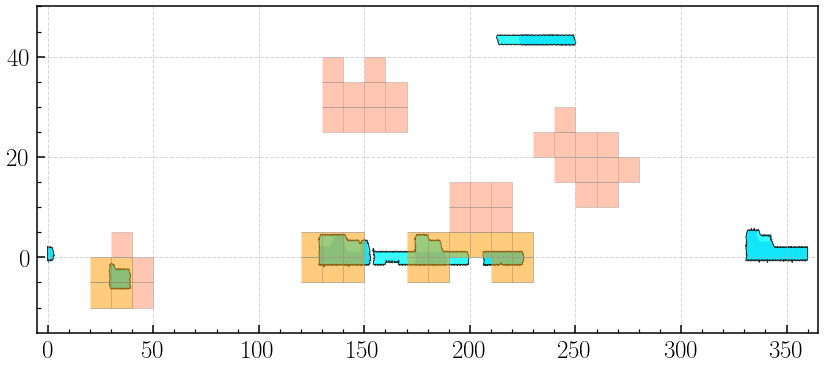

In [163]:
s19a_poly = io.read_from_pickle('../../damascus/data/hsc/s19a_fdfc_poly.pkl')
s18a_poly = io.read_from_pickle('../../damascus/data/hsc/s18a_fdfc_poly.pkl')

s18a_polygons = [Polygon(s18a_poly[idx + 1], closed=False) for idx in np.arange(len(s18a_poly))]
s19a_polygons = [Polygon(s19a_poly[idx + 1], closed=False) for idx in np.arange(len(s19a_poly))]

sweep_boxes = [sweep.sweep_to_box(name) for name in sweep_list]
sweep_polygons = [Polygon(box, closed=False) for box in sweep_boxes]

overlap_boxes = [sweep.sweep_to_box(name) for name in sweep_s19a_overlap]
overlap_polygons = [Polygon(box, closed=False) for box in overlap_boxes]

# 
fig, ax = plt.subplots(figsize=(14, 6))

ax.add_collection(PatchCollection(s18a_polygons, facecolor='royalblue', edgecolor='none', alpha=0.8))
ax.add_collection(PatchCollection(s19a_polygons, facecolor='cyan', edgecolor='k', alpha=0.8))

ax.add_collection(PatchCollection(sweep_polygons, edgecolor='gray', facecolor='orangered', alpha=0.3))
ax.add_collection(PatchCollection(overlap_polygons, edgecolor='gray', facecolor='gold', alpha=0.3))

ax.set_xlim(-5, 365)
ax.set_ylim(-15, 50)

In [9]:
%time sweep_test = Table.read(sweep_list[3])

CPU times: user 486 ms, sys: 4.35 s, total: 4.84 s
Wall time: 46.8 s


In [10]:
%time sweep_test = fits.open(sweep_list[3], memmap=True)[1].data

CPU times: user 499 ms, sys: 905 ms, total: 1.4 s
Wall time: 1.41 s


In [16]:
utils.flux_to_mag(sweep_test['FLUX_G'] / sweep_test['MW_TRANSMISSION_G'], zeropoint=22.5)

/Users/song/Dropbox/work/project/damascus/damascus/utils.py:17: RuntimeWarning: divide by zero encountered in log10
  return -2.5 * np.log10(flux) + zeropoint
/Users/song/Dropbox/work/project/damascus/damascus/utils.py:17: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(flux) + zeropoint


array([24.492277, 24.89151 , 24.981392, ..., 25.068792, 24.4047  ,
       25.19842 ], dtype=float32)

In [21]:
sweep_test['TYPE'][0] == 'PSF'

True

In [18]:
sweep_test['TYPE'] == 'PSF'

array([ True,  True,  True, ...,  True,  True,  True])

In [17]:
np.unique(sweep_test['TYPE'])

chararray(['DEV', 'DUP', 'EXP', 'PSF', 'REX', 'SER'], dtype='<U3')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


(array([8.0000e+00, 3.3000e+01, 1.9200e+02, 8.9400e+02, 2.5240e+03,
        6.2840e+03, 1.3929e+04, 3.5460e+03, 9.5000e+01, 1.4000e+01]),
 array([ 8.754578, 10.905259, 13.055941, 15.206623, 17.357304, 19.507986,
        21.658669, 23.80935 , 25.960032, 28.110712, 30.261395],
       dtype=float32),
 <a list of 10 Patch objects>)

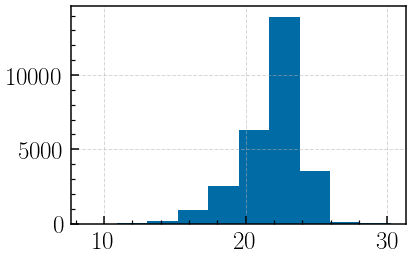

In [13]:
mag_r = -2.5 * np.log10(sweep_test['FLUX_R']) + 22.5

plt.hist(mag_r[np.isfinite(mag_r)])

In [50]:
print(len(sweep_test))

36778


In [11]:
print(sweep_test.colnames)

['RELEASE', 'BRICKID', 'BRICKNAME', 'OBJID', 'TYPE', 'RA', 'DEC', 'RA_IVAR', 'DEC_IVAR', 'DCHISQ', 'EBV', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'FLUX_W1', 'FLUX_W2', 'FLUX_W3', 'FLUX_W4', 'FLUX_IVAR_G', 'FLUX_IVAR_R', 'FLUX_IVAR_Z', 'FLUX_IVAR_W1', 'FLUX_IVAR_W2', 'FLUX_IVAR_W3', 'FLUX_IVAR_W4', 'MW_TRANSMISSION_G', 'MW_TRANSMISSION_R', 'MW_TRANSMISSION_Z', 'MW_TRANSMISSION_W1', 'MW_TRANSMISSION_W2', 'MW_TRANSMISSION_W3', 'MW_TRANSMISSION_W4', 'NOBS_G', 'NOBS_R', 'NOBS_Z', 'NOBS_W1', 'NOBS_W2', 'NOBS_W3', 'NOBS_W4', 'RCHISQ_G', 'RCHISQ_R', 'RCHISQ_Z', 'RCHISQ_W1', 'RCHISQ_W2', 'RCHISQ_W3', 'RCHISQ_W4', 'FRACFLUX_G', 'FRACFLUX_R', 'FRACFLUX_Z', 'FRACFLUX_W1', 'FRACFLUX_W2', 'FRACFLUX_W3', 'FRACFLUX_W4', 'FRACMASKED_G', 'FRACMASKED_R', 'FRACMASKED_Z', 'FRACIN_G', 'FRACIN_R', 'FRACIN_Z', 'ANYMASK_G', 'ANYMASK_R', 'ANYMASK_Z', 'ALLMASK_G', 'ALLMASK_R', 'ALLMASK_Z', 'WISEMASK_W1', 'WISEMASK_W2', 'PSFSIZE_G', 'PSFSIZE_R', 'PSFSIZE_Z', 'PSFDEPTH_G', 'PSFDEPTH_R', 'PSFDEPTH_Z', 'GALDEPTH_G', 'GALDEPTH

In [14]:
sweep_test['MW_TRANSMISSION_R']

array([0.94814384, 0.94814676, 0.94815373, ..., 0.95754325, 0.9567486 ,
       0.9571302 ], dtype=float32)

In [71]:
sweep_list = list_all_sweep_catalogs(sweep_dir)

s19a_fdfc = read_healpix_mask(s19a_fdfc_mask)

matches = [filter_hsc_fdfc_mask(sweep, s19a_fdfc) for sweep in sweep_list]

# Find 50 SWEEP files
NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
Ordering converted to NEST
# Find 48692 objects inside the FDFC region
# Find 23804 objects inside the FDFC region
# Find 3461144 objects inside the FDFC region
# Find 1486488 objects inside the FDFC region
# Find 0 objects inside the FDFC region
# Find 0 objects inside the FDFC region
# Find 0 objects inside the FDFC region
# Find 134507 objects inside the FDFC region
# Find 300026 objects inside the FDFC region
# Find 1351614 objects inside the FDFC region
# Find 2761847 objects inside the FDFC region
# Find 0 objects inside the FDFC region
# Find 0 objects inside the FDFC region
# Find 0 objects inside the FDFC region
# Find 132510 objects inside the FDFC region
# Find 262544 objects inside the FDFC region
# Find 0 objects inside the FDFC region
# Find 0 objects inside the FDFC region
# Find 0 objects inside the FDFC region
# Find 0 objects inside the FDFC region
# Find 0 objects inside the FDFC regi

In [74]:
matches_use = list(filter(None, matches)) 

print(len(matches_use))

18


In [76]:
dr9sv_matches = vstack(matches_use)

In [77]:
len(dr9sv_matches)

16695183

In [ ]:
dr9sv_matches.write('/Volumes/astro5/massive/decals/dr9sv/dr9sv_sweep_s19a_fdfc_all.fits')